In [1]:
import keras
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import math
import os
from keras.layers import *
from keras.models import *
from keras.optimizers import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score

Using TensorFlow backend.


In [2]:
MANIFEST_DIR = "./train.csv"
TEST_MANIFEST_DIR = "./test_data.csv"
Batch_size = 20
Long = 792
Lens = 633

把标签转成oneHot

In [3]:
def convert2oneHot(index,Lens):
    hot = np.zeros((Lens,))
    hot[int(index)] = 1
    return(hot)

训练集数据读取

In [4]:
def xs_gen(path=MANIFEST_DIR,batch_size = Batch_size,train=True,Lens=Lens):

    data_list = pd.read_csv(path)
    if train:
        data_list = np.array(data_list)[:Lens]
        print("Found %s train items."%len(data_list))
        print("list 1 is",data_list[0,-1])
        steps = math.ceil(len(data_list) / batch_size)    # 确定每轮有多少个batch
    else:
        data_list = np.array(data_list)[Lens:]
        print("Found %s test items."%len(data_list))
        print("list 1 is",data_list[0,-1])
        steps = math.ceil(len(data_list) / batch_size)    # 确定每轮有多少个batch
    while True:
        for i in range(steps):
            batch_list = data_list[i * batch_size : i * batch_size + batch_size]
            np.random.shuffle(batch_list)
            batch_x = np.array([file for file in batch_list[:,1:-1]])
            batch_y = np.array([convert2oneHot(label,10) for label in batch_list[:,-1]])

            yield batch_x, batch_y

验证集数据读取

In [5]:
def val_gen(path=MANIFEST_DIR,batch_size = 159):

    data_list = pd.read_csv(path)
    data_list = np.array(data_list)[:159]
    print("Found %s train items."%len(data_list))
    print("list 1 is",data_list[0,-1])
    steps = math.ceil(len(data_list) / batch_size)    # 确定每轮有多少个batch
    while True:
        for i in range(steps):
            batch_list = data_list[i * batch_size : i * batch_size + batch_size]
            #np.random.shuffle(batch_list)            
            batch_x = np.array([file for file in batch_list[:,1:-1]])
            batch_y = np.array([label for label in batch_list[:,-1]])

            yield batch_x,batch_y

测试集数据读取

In [6]:
def ts_gen(path=TEST_MANIFEST_DIR,batch_size = Batch_size):

    data_list = pd.read_csv(path)
    data_list = np.array(data_list)[:Lens]
    print("Found %s train items."%len(data_list))
    print("list 1 is",data_list[0,-1])
    steps = math.ceil(len(data_list) / batch_size)    # 确定每轮有多少个batch
    while True:
        for i in range(steps):
            batch_list = data_list[i * batch_size : i * batch_size + batch_size]
            batch_x = np.array([file for file in batch_list[:,1:]])

            yield batch_x

CNN搭建

In [7]:
TIME_PERIODS = 6000
def build_model(input_shape=(TIME_PERIODS,),num_classes=10):
    model = Sequential()
    model.add(Reshape((TIME_PERIODS, 1), input_shape=input_shape))
    model.add(Conv1D(16, 8,strides=2, activation='relu',input_shape=(TIME_PERIODS,1)))

    model.add(Conv1D(16, 8,strides=2, activation='relu',padding="same"))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(64, 4,strides=2, activation='relu',padding="same"))
    model.add(Conv1D(64, 4,strides=2, activation='relu',padding="same"))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, 4,strides=2, activation='relu',padding="same"))
    model.add(Conv1D(256, 4,strides=2, activation='relu',padding="same"))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(512, 2,strides=1, activation='relu',padding="same"))
    model.add(Conv1D(512, 2,strides=1, activation='relu',padding="same"))
    model.add(MaxPooling1D(2))

    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return(model)

定义函数画训练曲线

In [8]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))
        

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        #acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        #plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            #plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc')
        plt.legend(loc="lower right")
        fig=plt.gcf()
        plt.show()
        fig.savefig('./output.png')

模型训练

In [9]:
Train = True
if __name__ == "__main__":

    if Train == True:
        train_iter = xs_gen()

        val_iter = xs_gen(train=False)

        ckpt = keras.callbacks.ModelCheckpoint(
            filepath='best_model.{epoch:02d}-{val_loss:.4f}.h5',
            monitor='val_loss', save_best_only=True,verbose=1)

        model = build_model()
        opt = Adam(0.0002)
        model.compile(loss='categorical_crossentropy',
                    optimizer=opt, metrics=['accuracy'])
        print(model.summary())

        history = LossHistory()

        model.fit_generator(
            generator=train_iter,
            steps_per_epoch=Lens//Batch_size,
            epochs=50,
            initial_epoch=0,
            validation_data = val_iter,
            nb_val_samples = (Long - Lens)//Batch_size,
            callbacks=[ckpt,history],
            )
        model.save("finishModel.h5")
    else:
        test_iter = ts_gen()
        model = load_model("best_model.49-0.00.h5")
        pres = model.predict_generator(generator=test_iter,steps=math.ceil(528/Batch_size),verbose=1)
        print(pres.shape)
        ohpres = np.argmax(pres,axis=1)
        print(ohpres.shape)
        img_list = pd.read_csv(TEST_MANIFEST_DIR)
        df = pd.DataFrame()
        df["id"] = np.arange(1,len(ohpres)+1)
        df["label"] = ohpres
        df.to_csv("result_cnn.csv",index = False,encoding = "utf-8")


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 6000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2997, 16)          144       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1499, 16)          2064      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 749, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 375, 64)           4160      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 188, 64)           16448     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 94, 64)          

绘制曲线

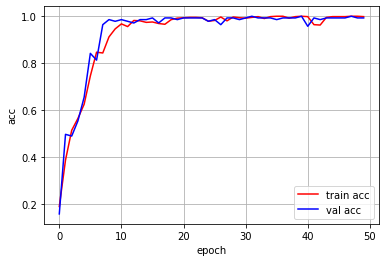

In [10]:
history.loss_plot('epoch')

混淆矩阵、F1 score

In [11]:
Train = False
if __name__ == "__main__":

    if Train == True:
        train_iter = xs_gen()

        val_iter = xs_gen(train=False)

        ckpt = keras.callbacks.ModelCheckpoint(
            filepath='best_model.{epoch:02d}-{val_loss:.4f}.h5',
            monitor='val_loss', save_best_only=True,verbose=1)

        model = build_model()
        opt = Adam(0.0002)
        model.compile(loss='categorical_crossentropy',
                    optimizer=opt, metrics=['accuracy'])
        print(model.summary())

        history = LossHistory()
        cbk = my_callback()

        model.fit_generator(
            generator=train_iter,
            steps_per_epoch=Lens//Batch_size,
            epochs=50,
            initial_epoch=0,
            validation_data = val_iter,
            nb_val_samples = (Long - Lens)//Batch_size,
            callbacks=[ckpt,history],
            )
        model.save("finishModel.h5")
    else:
        test_iter = val_gen()
        for x,y in val_gen():
            x1 = x[0]
            y1 = y[0]
            break
        label = y
        model = load_model("best_model.45-0.0003.h5")
        pres = model.predict_generator(generator=test_iter,steps=math.ceil(159/159),verbose=1)
        print(pres.shape)
        ohpres = np.argmax(pres,axis=1)
        print(ohpres.shape)

Found 159 train items.
list 1 is 7.0
Found 159 train items.
list 1 is 7.0
1/1 [==============================] - 4s 4s/step
(159, 10)
(159,)


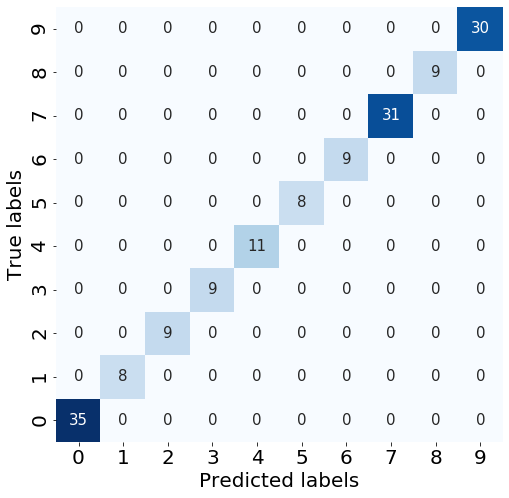

In [12]:
con_mat = confusion_matrix(label,ohpres)
plt.figure(figsize=(8, 8))
sns.heatmap(con_mat, annot=True, cmap='Blues',cbar=False, annot_kws={'size':15})

plt.ylim(0, 10)
plt.xlabel('Predicted labels',fontsize=20)
plt.ylabel('True labels',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [13]:
p = precision_score(label,ohpres, average='macro')
r = recall_score(label,ohpres, average='macro')
print('Precision:{};recall:{}'.format(p,r))
f1_result = f1_score(label,ohpres, average='macro')
print(f1_result)

Precision:1.0;recall:1.0
1.0


测试集测试

In [14]:
if __name__ == "__main__":

    if Train == True:
        train_iter = xs_gen()
        val_iter = xs_gen(train=False)

        ckpt = keras.callbacks.ModelCheckpoint(
            filepath='best_model.{epoch:02d}-{val_loss:.4f}.h5',
            monitor='val_loss', save_best_only=True,verbose=1)

        model = build_model()
        opt = Adam(0.0002)
        model.compile(loss='categorical_crossentropy',
                    optimizer=opt, metrics=['accuracy'])
        print(model.summary())

        model.fit_generator(
            generator=train_iter,
            steps_per_epoch=Lens//Batch_size,
            epochs=50,
            initial_epoch=0,
            validation_data = val_iter,
            nb_val_samples = (Long - Lens)//Batch_size,
            callbacks=[ckpt],
            )
        model.save("finishModel.h5")
    else:
        test_iter = ts_gen()
        model = load_model("best_model.45-0.0003.h5")
        pres = model.predict_generator(generator=test_iter,steps=math.ceil(528/Batch_size),verbose=1)
        print(pres.shape)
        ohpres = np.argmax(pres,axis=1)
        print(ohpres.shape)
        img_list = pd.read_csv(TEST_MANIFEST_DIR)
        df = pd.DataFrame()
        df["id"] = np.arange(1,len(ohpres)+1)
        df["label"] = ohpres
        df.to_csv("submmit.csv",index = False,encoding = "utf-8")

Found 528 train items.
list 1 is -0.04020269461077845
27/27 [==============================] - 4s 135ms/step
(528, 10)
(528,)
